In [2]:
import os
import sys
import time
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)

import FLTrack.utils as utils
from FLTrack.models import ShallowNN
from FLTrack.evals import evaluate_mae_with_confidence
from FLTrack.evals import influence
from FLTrack.evals import evaluate
from FLTrack.eccentricity import euclidean_distance, accumulated_proximity, hessian_eccentricity

features = 169
batch_size = 64
loss_fn = torch.nn.L1Loss()

In [3]:
client_ids = [f"c{i}" for i in range(1, 25)]

In [4]:
def eval(model, loss_fn, dataloader) -> float:
    """
    Evaluate the model with validation dataset.

    Parameters:
    ------------
    model: torch.nn.Module object; model to be evaluated
    loss_fn: torch.nn.Module object; loss function

    Returns:
    ------------
    loss_avg: float; average loss
    """
    batch_loss = []
    for _, (x, y) in enumerate(dataloader):
        outputs = model(x)
        y = y.view(-1, 1)
        loss = loss_fn(outputs, y)
        batch_loss.append(loss.item())
    loss_avg = sum(batch_loss) / len(batch_loss)

    return loss_avg

## Isolated Model Performance

In [6]:
for client in client_ids:
    val_data_path =  "../testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    val_loader = DataLoader(val_set, batch_size, shuffle = True)
    isolated_model_path = "../FLTrack/checkpt/isolated/epoch_250/batch256_client_"+str(client)+".pth"
    isolated_model =  ShallowNN(169)
    isolated_model.load_state_dict(torch.load(isolated_model_path))
    print(str(client), eval(isolated_model, loss_fn, val_loader))

c1 1.2448173184548654
c2 1.5595299512781995
c3 1.9419097304344177
c4 1.2287787230391252
c5 1.2227578461170197
c6 1.331301513645384
c7 1.6446248590946198
c8 1.7471107993807111
c9 1.6413296305614968
c10 1.2675633287948112
c11 1.169335653653016
c12 1.5643055298749138
c13 1.9531276784837246
c14 1.0858797104585738
c15 2.0104206562042237
c16 1.719310571750005
c17 1.5549181135077226
c18 2.326359521258961
c19 1.2819792156995728
c20 1.4047927298853475
c21 1.5045307052546535
c22 1.6499600580760412
c23 1.0989618081113566
c24 1.9729837002577606


## Federated Model Performance

In [11]:
global_model = ShallowNN(features)
global_model.load_state_dict(torch.load('../FLTrack/checkpt/fedl/epoch_250/25_rounds_10_epochs_per_round/global_model.pth'))

<All keys matched successfully>

In [12]:
mae = []
for client in client_ids:
    val_data_path =  "../testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    val_loader = DataLoader(val_set, batch_size, shuffle = True,drop_last=True )
    mae.append(eval(global_model, loss_fn, val_loader))
    print(str(client), round(eval(global_model, loss_fn, val_loader),4))

c1 1.4408
c2 1.5234
c3 1.5269
c4 1.8864
c5 1.4302
c6 1.4552
c7 1.552
c8 1.6741
c9 2.154
c10 1.9751
c11 1.7867
c12 1.5772
c13 2.5982
c14 1.505
c15 1.6891
c16 1.4583
c17 1.5773
c18 2.1372
c19 1.7337
c20 1.4917
c21 1.399
c22 2.7562
c23 1.7924
c24 1.7219


## Error Bars for Federated Learning vs Isolated Training

In [9]:
eval_list = []
for client in client_ids:
    val_data_path =  "../testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    val_loader = DataLoader(val_set, batch_size, shuffle = True)
    
    isolated_model_path = "../FLTrack/checkpt/isolated/epoch_250/batch256_client_"+str(client)+".pth"
    isolated_model =  ShallowNN(features)
    isolated_model.load_state_dict(torch.load(isolated_model_path))
    
    isolated_mae,(iso_lower_band, iso_upper_band), _  = evaluate_mae_with_confidence(isolated_model, val_loader)
    federated_mae,(fed_lower_band, fed_upper_band), _ = evaluate_mae_with_confidence(global_model,val_loader)
    
    eval_dict = {"client_id":client, "Isolated Average MAE": round(isolated_mae, 4),
                 "Isolated MAE lower band":round(iso_lower_band,4),
                 "Isolated MAE upper band":round(iso_upper_band,4),
                 "Federated Average MAE" :round(federated_mae, 4),
                "Federated MAE lower band": round(fed_lower_band, 4),
                "Federated MAE upper band":round(fed_upper_band,4)}
    eval_list.append(eval_dict)
    
eval_df = pd.DataFrame.from_dict(eval_list)
eval_df["clients"] = [i for i in range(1,25)] 

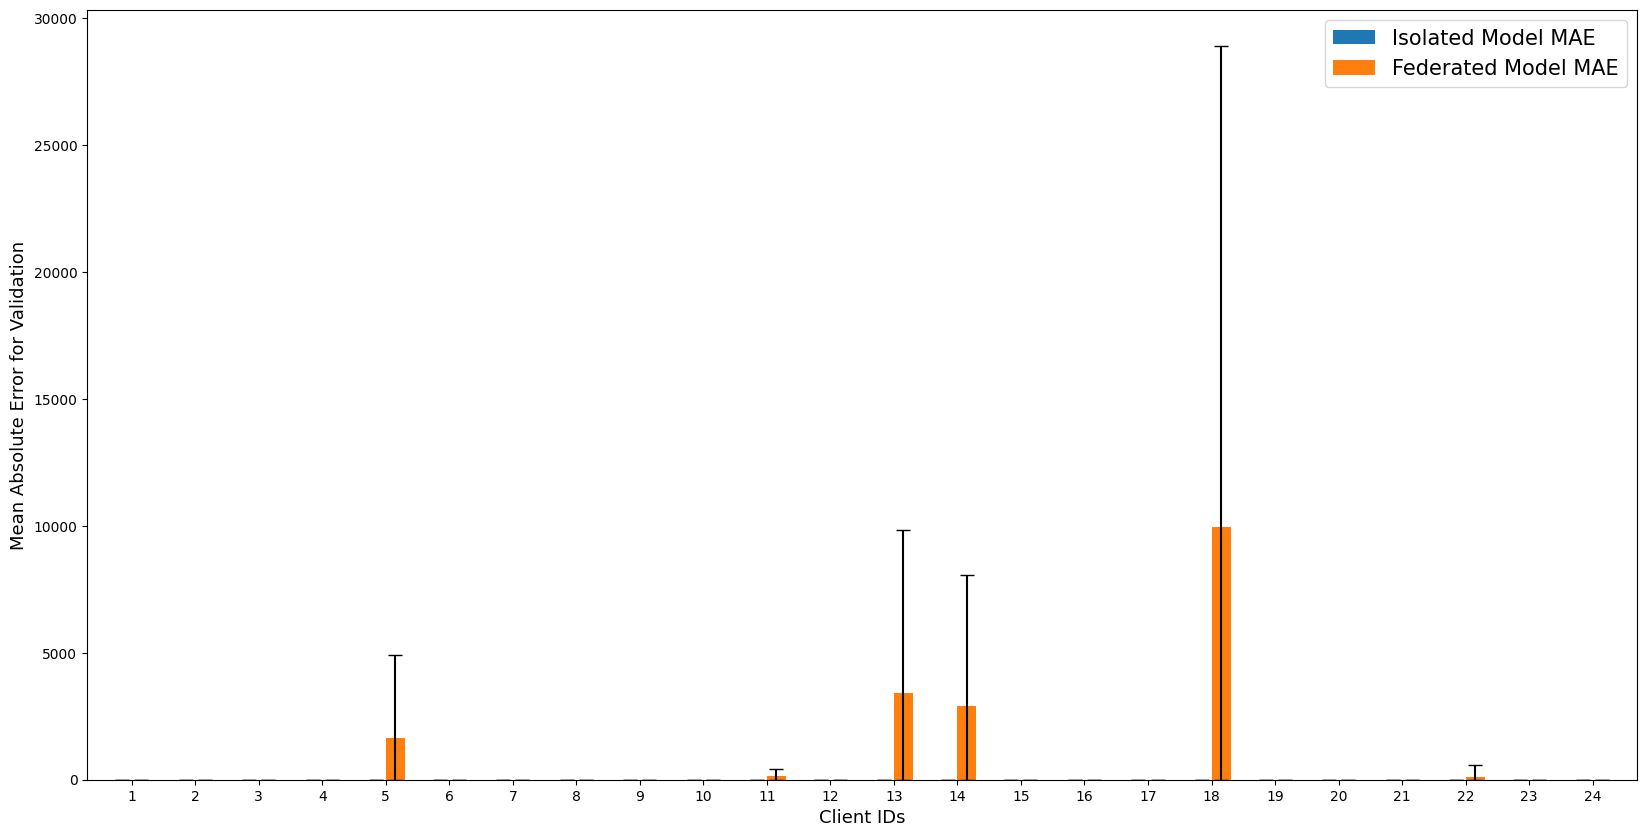

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.3
index = eval_df.index

bar1 = ax.bar(index - bar_width / 2, eval_df['Isolated Average MAE'], bar_width, yerr=[
    (eval_df["Isolated Average MAE"] - eval_df["Isolated MAE lower band"]),
    (eval_df['Isolated MAE upper band'] - eval_df["Isolated Average MAE"])
], capsize=5, label='Isolated Model MAE')

bar2 = ax.bar(index + bar_width / 2, eval_df['Federated Average MAE'], bar_width, yerr=[
    (eval_df["Federated Average MAE"] - eval_df["Federated MAE lower band"]),
    (eval_df['Federated MAE upper band'] - eval_df["Federated Average MAE"])
], capsize=5, label='Federated Model MAE')

ax.set_xlabel('Client IDs', fontdict={'fontsize': 13})
ax.set_ylabel("Mean Absolute Error for Validation", fontdict={'fontsize': 13})
ax.set_xticks(index)
ax.set_xticklabels(eval_df['clients'])
ax.legend(fontsize=15, loc="upper right")

# Adjust the xlim to decrease space at the left and right edges
ax.set_xlim(index[0] - 0.7, index[-1] + 0.7)

plt.show()

## Influence with prediction difference at 500 global rounds

In [ ]:
inf_val = []
for client in client_ids:
    model = ShallowNN(features)
    model.load_state_dict(torch.load('../checkpt/epoch_500/influence/' + str(client)+ '_fedl_global_500.pth'))
    val_data_path =  "../testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    inf = influence(global_model,model,val_set)
    inf_val.append(round(inf.item(),4))
   
data = {"client id": client_ids, "inf_val": inf_val}
data = pd.DataFrame(data)
data.to_csv("../insights/influence_with_pred_diff_ex1.csv" , index=False)

## Influence with prediction difference at 1 global round and 25 local rounds

In [ ]:
def influence(
    model: torch.nn.Module,
    influenced_model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
) -> float:
    """
    Calculate the influence of the model on the influenced model for the given validation set based on the prediction difference.

    Parameters:
    -------------
    model: torch.nn.Module object;
        Model trained with all the clients.
    influenced_model: torch.nn.Module object;
        Model trained without a specific client.
    data_loader: torch.utils.data.DataLoader object;
        Validation dataset.
/'
    Returns:
    -------------
    influence: float;
        Influence of the model on the influenced model
    """

    batch_inf = []
    for _, (x, y) in enumerate(dataloader):
        output = model(x)
        inf_output = influenced_model(x)
        inf = np.mean(np.abs(output.detach().numpy() - inf_output.detach().numpy()))
        batch_inf.append(inf.item())
    influence = sum(batch_inf) / len(batch_inf)

    return influence
        

In [ ]:

inf_val_test = []
for client in client_ids:
    influenced_model = ShallowNN(features)
    influenced_model.load_state_dict(torch.load('FLTrack/checkpt/influence/25_rounds_10_epochs/'+str(client)+'/global_model.pth'))
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    val_loader = DataLoader(val_set, batch_size, shuffle = True,drop_last=True )

    
    inf = influence(global_model,influenced_model,val_loader)
    
    print(client,round(inf,4))
    #inf_val_test.append(round(inf,4))
    
#data_test = {"client id": client_ids, "inf_val": inf_val_test}
#data_test = pd.DataFrame(data_test)
#data_test.to_csv("insights/influence_with_pred_diff_ex2.csv" , index=False)

## Influence with mae at 1 global round and 25 local rounds

In [ ]:
performance_inf = []
for client in client_ids:
    influenced_model = ShallowNN(features)
    influenced_model.load_state_dict(torch.load('FLTrack/checkpt/influence/25_rounds_10_epochs/'+str(client)+'/global_model.pth'))
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    val_loader = DataLoader(val_set, batch_size, shuffle = True)
    
    influenced_mae = eval(influenced_model, loss_fn, val_loader)
    global_mae = eval(global_model,loss_fn, val_loader)
    
    inf = global_mae - influenced_mae
    
    performance_inf.append(round(inf,4))

data = {"client id": client_ids, "inf_val": performance_inf}
data = pd.DataFrame(data)
#data.to_csv("influence_with_mae_ex2.csv" , index=False)

In [ ]:
data

## Eccentricity  $\xi^L$ 

$
\begin{equation}\label{eq:Ecc1}
\xi_i = \frac{2\sum_{j=1}^{k}d(\mathcal{H}_{\mu_i}, \mathcal{H}_{\mu_j})}{\sum_{l=1}^{k}\sum _{j=1}^{k} d(\mathcal{H}_{\mu_l}, \mathcal{H}_{\mu_j})},
\end{equation}
$

Where  $\mathcal{H}_{\mu_i}$ is the Hessian matrix of client $i$, and $d(.,.)$ is the Euclidean distance between the Hessian matrices of two clients. 

In [ ]:
local_matrix_dict = {
        key: torch.load("hessians/epoch_500/iso/" + str(key) + ".pth")
        for key in client_ids
    }

In [ ]:
ecce_dict = hessian_eccentricity(local_matrix_dict, euclidean_distance)
ecc_hessian = {"client id": client_ids, "hess_ecc": list(ecce_dict.values())}
ecc_hessian = pd.DataFrame(ecc_hessian)
ecc_hessian.to_csv("insights/eccentricity_with_hessian_euclidean_with_local_model.csv" , index=False)

## Eccentricity $\xi^G$ 

$
\begin{equation}\label{eq:Ecc1}
\xi_i = \frac{2\sum_{j=1}^{k}d(\mathcal{H}^i_{\mathcal M}, \mathcal{H}^j_{\mathcal M})}{\sum_{l=1}^{k}\sum _{j=1}^{k} d(\mathcal{H}^l_{\mathcal M}, \mathcal{H}^j_{\mathcal M})},
\end{equation}
$

where $\mathcal{H}^i_{\mathcal M}$ is the Hessian matrix of client $i$, and $d(.,.)$ is the Euclidean distance between the Hessian matrices global with respect to the validation dataset of clients $i$. 

In [ ]:
global_matrix_dict = {
        key: torch.load("hessians/epoch_500/fed/" + str(key) + ".pth")
        for key in client_ids
    }

In [ ]:
ecce_dict_g = hessian_eccentricity(global_matrix_dict, euclidean_distance)
ecc_hessian_g = {"client id": client_ids, "hess_ecc": list(ecce_dict_g.values())}
ecc_hessian_g = pd.DataFrame(ecc_hessian)
ecc_hessian_g.to_csv("insights/eccentricity_with_hessian_euclidean_with_globall_model.csv" , index=False)

In [ ]:
import numpy as np

# Original lists
l1 = np.array([0.0432, 0.0402, 0.0386, 0.0452, 0.04, 0.038, 0.0377, 0.036,
               0.04, 0.0453, 0.0394, 0.0362, 0.0381, 0.0523, 0.042, 0.045,
               0.04, 0.0475, 0.0501, 0.0424, 0.0383, 0.0368, 0.0457, 0.0417])
l2 = np.array([0.8917, 0.9621, 1.0665, 1.4851, 5.0129, 1.0305, 1.0048, 2.0591,
               1.3992, 1.7189, 3.6455, 0.4959, 13.4899, 5.7832, 1.4255, 1.417,
               1.0406, 12.922, 1.2767, 1.6468, 0.9006, 3.5644, 1.2182, 1.2461])

# Sort lists
l1_sorted = np.sort(l1)
l2_sorted = np.sort(l2)

# Calculate quantiles
quantiles_l1 = np.arange(0, 1, 1/len(l1_sorted))
quantiles_l2 = np.arange(0, 1, 1/len(l2_sorted))

# Use interpolation to find adjusted values of l1
adjusted_l1 = np.interp(quantiles_l2, quantiles_l1, l1_sorted)

print("Adjusted l1:", adjusted_l1)


In [ ]:
import numpy as np
from scipy.stats import pearsonr

# Original lists
l1 = np.array([0.0432, 0.0402, 0.0386, 0.0452, 0.04, 0.038, 0.0377, 0.036,
               0.04, 0.0453, 0.0394, 0.0362, 0.0381, 0.0523, 0.042, 0.045,
               0.04, 0.0475, 0.0501, 0.0424, 0.0383, 0.0368, 0.0457, 0.0417])
l2 = np.array([0.8917, 0.9621, 1.0665, 1.4851, 5.0129, 1.0305, 1.0048, 2.0591,
               1.3992, 1.7189, 3.6455, 0.4959, 13.4899, 5.7832, 1.4255, 1.417,
               1.0406, 12.922, 1.2767, 1.6468, 0.9006, 3.5644, 1.2182, 1.2461])

# Calculate the original correlation
original_corr, _ = pearsonr(adjusted_l1, l2)
print("Original correlation:", original_corr)

# Brute-force search for optimal values of a and b
best_corr = original_corr
best_a = 2.0
best_b = 0.0

for a in np.linspace(0.9, 1.1, 100):
    for b in np.linspace(-0.05, 0.05, 100):
        modified_l1 = a * l1 + b
        corr, _ = pearsonr(modified_l1, l2)
        if corr > best_corr:
            best_corr = corr
            best_a = a
            best_b = b

print("Best correlation:", best_corr)
print("Best a:", best_a)
print("Best b:", best_b)

# Apply the transformation to l1
new_l1 = best_a * l1 + best_b
print("Modified l1:", new_l1)
